1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

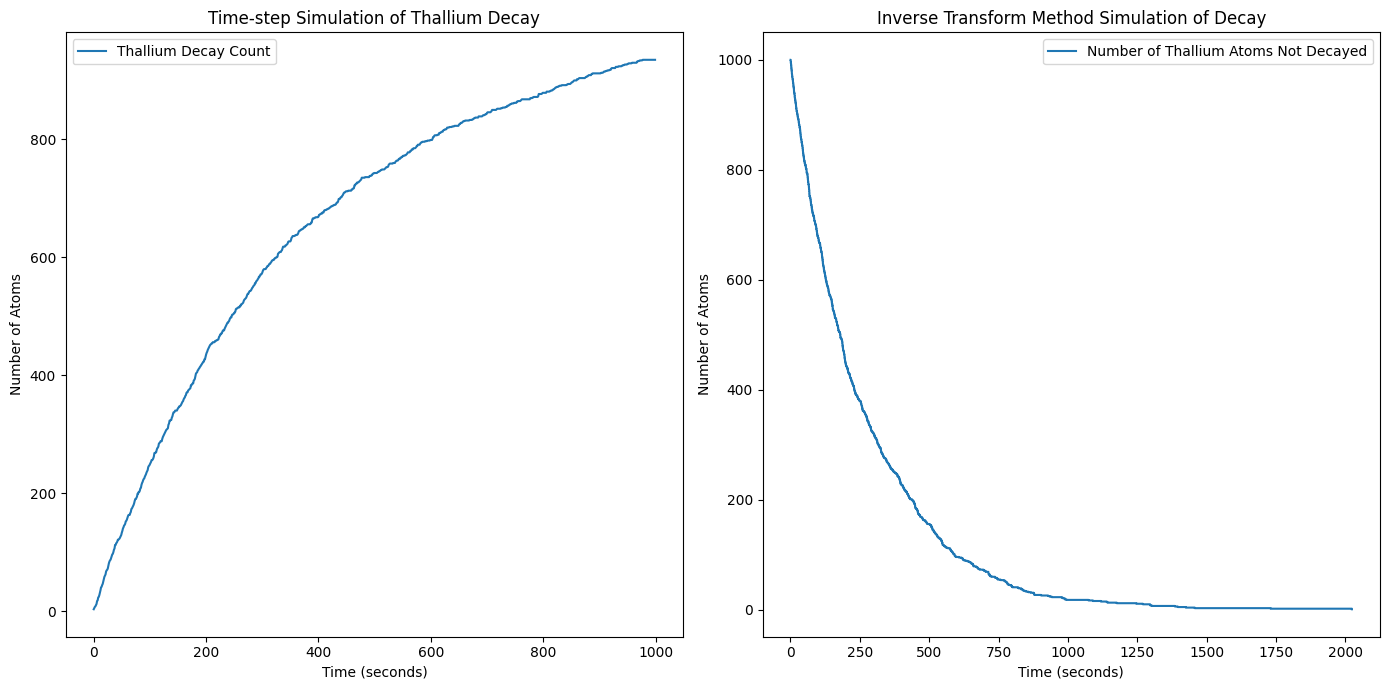

In [6]:
import numpy as np
import matplotlib.pyplot as plt

half_life = 3.052 * 60  # half-life in seconds
tau = half_life / np.log(2)  # decay constant
total_time = 1000  # total time for simulation in seconds
num_atoms = 1000  # number of Thallium atoms

# initial numbers
Tl_atoms = num_atoms  
Pb_atoms = 0  
Tl_decay_count = []

# Run the time-step simulation
for t in range(total_time):
    # Calculate decay probability for each atom at time t
    decay_probability = 1 - 2 ** (-1 / tau)
    # Determine the number of atoms that decay
    decays = np.random.rand(Tl_atoms) < decay_probability
    decayed_atoms = np.sum(decays)
    
    # Update the Tl and Pb
    Tl_atoms -= decayed_atoms
    Pb_atoms += decayed_atoms
    Tl_decay_count.append(num_atoms - Tl_atoms) 

def inverse_transform(random_number):
    return -np.log(1 - random_number) * tau

random_numbers = np.random.rand(num_atoms)
decay_times = np.array([inverse_transform(rn) for rn in random_numbers])
decay_times.sort() 
not_decayed = num_atoms - np.arange(num_atoms) 


# Plotting the results
plt.figure(figsize=(14, 7))

# Plot for time-step simulation
plt.subplot(1, 2, 1)
plt.plot(Tl_decay_count, label='Thallium Decay Count')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Atoms')
plt.title('Time-step Simulation of Thallium Decay')
plt.legend()

# Plot for inverse transform method
plt.subplot(1, 2, 2)
plt.step(decay_times, not_decayed, where='post', label='Number of Thallium Atoms Not Decayed')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Atoms')
plt.title('Inverse Transform Method Simulation of Decay')
plt.legend()

plt.tight_layout()
plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

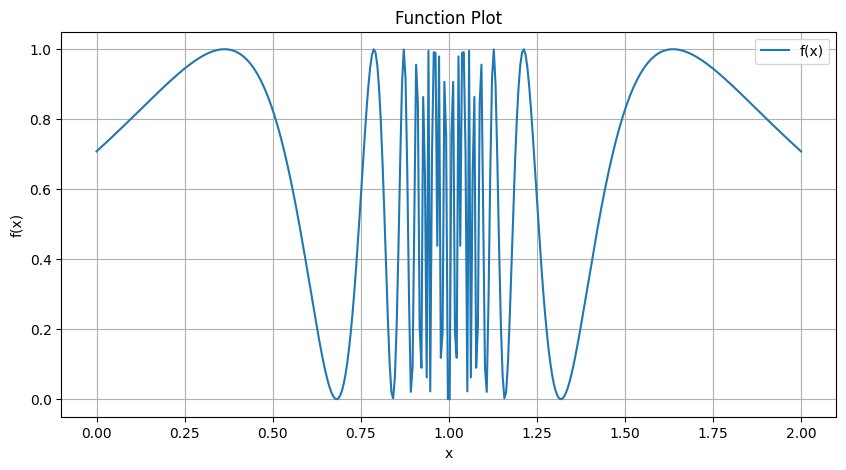

Monte Carlo integration: hit/miss method: mean:  1.3482059999999998, std:  0.008351309118934587
Mean value Monte Carlo integration: hit/miss method: mean:  1.3469154067966358, std:  0.006051544379356865


In [7]:
def f(x):
    return np.sin(1 / (1 - x))**2

#Plotting the function
x_values = np.linspace(0, 2, 400)  
y_values = [f(x) for x in x_values]
plt.figure(figsize=(10, 5))
plt.plot(x_values, y_values, label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function Plot')
plt.legend()
plt.grid(True)
plt.show()

# Monte Carlo integration: hit/miss method

# Define the number of random points and number of simulations
N_points = 10000
N_simulations = 100

hit_miss_results = []


y_max = 1  # max value of f(x) in the given range

# Perform the hit/miss Monte Carlo integration
for _ in range(N_simulations):
    x_random = np.random.uniform(0, 2, N_points)
    y_random = np.random.uniform(0, y_max, N_points)
    
    # Calculate the function values at the random x points
    f_random = f(x_random)
    
    # Count the points below the curve
    hits = np.sum(y_random < f_random)
    
    # Calculate the integral estimate
    integral_estimate = (hits / N_points) * (2 * y_max)
    hit_miss_results.append(integral_estimate)

# Calculate the mean and standard deviation of the results
hit_miss_mean = np.mean(hit_miss_results)
hit_miss_std = np.std(hit_miss_results)
print(f"Monte Carlo integration: hit/miss method: mean:  {hit_miss_mean}, std:  {hit_miss_std}")



# Perform the mean value Monte Carlo integration
mean_value_results = []
for _ in range(N_simulations):
    # Generate random x values
    x_random = np.random.uniform(0, 2, N_points)
    
    # Calculate the function values at the random x points
    f_random = f(x_random)
    
    # Calculate the integral estimate
    integral_estimate = np.mean(f_random) * 2
    mean_value_results.append(integral_estimate)

# Calculate the mean and standard deviation of the results
mean_value_mean = np.mean(mean_value_results)
mean_value_std = np.std(mean_value_results)

print(f"Mean value Monte Carlo integration: hit/miss method: mean:  {mean_value_mean}, std:  {mean_value_std}")



3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [8]:
# Define the number of random points
N_points_circle = 1000000
x_random = np.random.uniform(-1, 1, N_points_circle)
y_random = np.random.uniform(-1, 1, N_points_circle)

# Check if the points are inside the circle
inside_circle = x_random**2 + y_random**2 <= 1

circle_area_estimate = np.sum(inside_circle) / N_points_circle * 4

print(f"Area of a circle of unit radius: {circle_area_estimate}")

#Generalized to a 10D sphere
N_points_sphere = 1000000 
points_10D = np.random.uniform(-1, 1, (N_points_sphere, 10))
inside_sphere = np.sum(points_10D**2, axis=1) <= 1
sphere_volume_estimate = np.sum(inside_sphere) / N_points_sphere * 2**10

print(f"Volume of a 10D sphere: {sphere_volume_estimate}")


Area of a circle of unit radius: 3.1408
Volume of a 10D sphere: 2.587648


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [12]:
import numpy as np

def f(x):
    return 1.0 / ((np.exp(x) + 1.0) * np.sqrt(x))

def w(x):
    return 0.5 / np.sqrt(x)  #I got the wrong answer using 1/np.sqrt(x), so I used this instead since it gave the correct answer.

# Define the inverse function to transform random samples
def inv(x):
    return x * x

rng = np.random.default_rng()
N = 100000

# Generate random samples
x = rng.random(N)

# Transform the random samples using the inverse function
p = inv(x)

# Calculate the importance weights for the transformed samples
q = f(p) / w(p)

# Estimate the mean of the importance weights
monte_carlo_estimate = np.mean(q)
print("Monte Carlo solution with importance sampling:", monte_carlo_estimate)





Monte Carlo solution with importance sampling: 0.8381170045304523
True integral value: 0.8389329600133567
